In [1]:
import pandas as pd
from pathlib import Path
from torch_geometric.data import download_url, extract_zip

In [2]:
from dataclasses import dataclass


@dataclass(frozen=True)
class FileArtifact:
    url: str
    path: Path
    force_download: bool = False

    def __post_init__(self):
        if self.path.exists() and not self.force_download:
            print(f"Using cached file '{self.path}'")
            return
        if not self.path.parent.exists():
            print(f"Creating directory '{self.path.parent}'")
            self.path.parent.mkdir(parents=True)
        print(f"Downloading file from '{self.url}' to '{self.path}'")
        download_url(self.url, self.path.parent, filename=self.file.name, log=False)

    def __repr__(self) -> str:
        return f"File from '{self.url}' is at path '{self.path}'"

    def __str__(self) -> str:
        return f"{self.path}"


@dataclass(frozen=True)
class ZipArtifact:
    url: str
    extract_at: Path
    expected_content: list[str]
    remove_zip: bool = False

    def __post_init__(self):
        if not self.extract_at.exists():
            print(f"Creating directory '{self.extract_at}'")
            self.extract_at.mkdir(parents=True)
        expected_content_exists = all(
            (self.extract_at / name).exists() for name in self.expected_content
        )
        if expected_content_exists:
            print(
                f"Using cached files from '{self.url}' extracted to '{self.extract_at}'"
            )
            return
        print(f"Downloading zip file from '{self.url}' to '{self.extract_at}'")
        path_to_zip = download_url(self.url, self.extract_at.parent, log=False)
        extract_zip(path_to_zip, self.extract_at, log=False)
        expected_content = set(self.expected_content)
        for new_file in self.extract_at.iterdir():
            if new_file.name in expected_content:
                expected_content.remove(new_file.name)
                continue
            print(f"Warning: got unexpected file '{new_file}'")
        if expected_content:
            print(f"Warning: missing expected files {expected_content}")
        if self.remove_zip:
            Path(path_to_zip).unlink()

    @property
    def path(self):
        return self.extract_at

    @property
    def contents(self) -> list[Path]:
        return [self.extract_at / name for name in self.expected_content]

In [3]:
HERE = Path(".")
ROOT = Path("..")


residue_atom_index_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/cj2801jszmj73cmhklycx/residue_atom_index.zip?rlkey=i5qzddjcb4jcbao19h6jgfx00&st=go9ujwsg&dl=1",
    ROOT / "data" / "processed",
    expected_content=["residue_atom_index"],
)


mask_pl_edge_residue_results_artifact = ZipArtifact(
    "https://www.dropbox.com/scl/fi/2vt532fkofgdth2ae6c19/mask_pl_edges_at_residue.zip?rlkey=1z14ykkh8fn5lvwafc17b2gef&st=zqe0osr0&dl=1",
    ROOT / "data" / "crocodoc",
    expected_content=["mask_pl_edges_at_residue"],
)

Using cached files from 'https://www.dropbox.com/scl/fi/cj2801jszmj73cmhklycx/residue_atom_index.zip?rlkey=i5qzddjcb4jcbao19h6jgfx00&st=go9ujwsg&dl=1' extracted to '../data/processed'
Using cached files from 'https://www.dropbox.com/scl/fi/2vt532fkofgdth2ae6c19/mask_pl_edges_at_residue.zip?rlkey=1z14ykkh8fn5lvwafc17b2gef&st=zqe0osr0&dl=1' extracted to '../data/crocodoc'


In [4]:
# TODO
# - add PLIP artifact
# - add kinodata 3D raw and processed artifact?

## Data loading 1: crocodoc output data pl edge masking at residues

In [5]:
mask_pl_edge_residue_result = mask_pl_edge_residue_results_artifact.contents[0]

In [6]:
# count number of csv files in source dir
print(len(list(mask_pl_edge_residue_result.glob("*.csv"))))

945


In [7]:
ref_dfs = []
attr_dfs = []
for csv_file in mask_pl_edge_residue_result.glob("*.csv"):
    if "None" in csv_file.name:
        continue
    print(csv_file.name)
    df = pd.read_csv(csv_file)
    if "cgnn3d" in csv_file.name:
        model = "CGNN-3D"
    elif "cgnn" in csv_file.name:
        model = "CGNN"
    else:
        model = None
    df["model"] = model
    if "reference" in csv_file.stem:
        ref_dfs.append(df)
        continue
    attr_dfs.append(df)

residue_delta_scaffold_0_cgnn_part_9.csv
residue_delta_scaffold_3_cgnn3d_part_84.csv
residue_delta_scaffold_0_cgnn3d_part_5.csv
residue_delta_scaffold_3_cgnn3d_part_53.csv
residue_delta_scaffold_1_cgnn3d_part_3.csv
residue_delta_scaffold_3_cgnn3d_part_47.csv
residue_delta_scaffold_4_cgnn3d_part_13.csv
residue_delta_scaffold_4_cgnn_part_50.csv
residue_delta_scaffold_1_cgnn3d_part_59.csv
residue_delta_scaffold_4_cgnn_part_44.csv
reference_scaffold_2_cgnn3d.csv
residue_delta_scaffold_1_cgnn3d_part_71.csv
residue_delta_scaffold_1_cgnn3d_part_65.csv
residue_delta_scaffold_4_cgnn_part_78.csv
residue_delta_scaffold_4_cgnn3d_part_0.csv
residue_delta_scaffold_0_cgnn3d_part_57.csv
residue_delta_scaffold_2_cgnn_part_14.csv
residue_delta_scaffold_0_cgnn3d_part_43.csv
residue_delta_scaffold_2_cgnn_part_28.csv
residue_delta_scaffold_3_cgnn_part_62.csv
residue_delta_scaffold_3_cgnn_part_76.csv
residue_delta_scaffold_0_cgnn3d_part_80.csv
residue_delta_scaffold_0_cgnn_part_40.csv
residue_delta_scaffold

In [8]:
attr_df = pd.concat(attr_dfs, axis=0)
ref = pd.concat(ref_dfs, axis=0)

In [9]:
attr_df.head()

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model
0,23315,6280856,3038,25,8.400028,GLY,G,CGNN
1,2099,747076,786,25,8.979584,ALA,A,CGNN
2,2803,1001015,14527,25,7.473264,ALA,A,CGNN
3,31318,12158574,1065,25,7.979068,ALA,A,CGNN
4,70124,17663250,6057,25,8.870531,ALA,A,CGNN


In [10]:
ref.head()

,ident,chembl_activity_id,klifs_structure_id,reference_pred,target,model
0,25977,7978870,786,5.954986,5.728158,CGNN-3D
1,65458,17633685,6057,6.753573,6.801343,CGNN-3D
2,47959,16312065,1415,8.294194,9.000000,CGNN-3D
3,70955,17670665,14978,7.218015,6.210419,CGNN-3D
4,40021,15061108,7177,6.884452,6.769551,CGNN-3D


In [11]:
attr_df = pd.merge(
    attr_df,
    ref[["chembl_activity_id", "reference_pred", "target", "model"]],
    on=["chembl_activity_id", "model"],
    how="left",
)

In [12]:
attr_df["delta"] = attr_df["reference_pred"] - attr_df["masked_pred"]

In [13]:
attr_df.head()

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta
0,23315,6280856,3038,25,8.400028,GLY,G,CGNN,8.400028,8.553953,0.000000
1,2099,747076,786,25,8.979584,ALA,A,CGNN,8.979579,8.920819,-0.000005
2,2803,1001015,14527,25,7.473264,ALA,A,CGNN,7.473276,6.892790,0.000012
3,31318,12158574,1065,25,7.979068,ALA,A,CGNN,7.979075,7.847712,0.000007
4,70124,17663250,6057,25,8.870531,ALA,A,CGNN,8.870525,8.420216,-0.000006


### Sanity check deltas for cgnn are close to zero

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

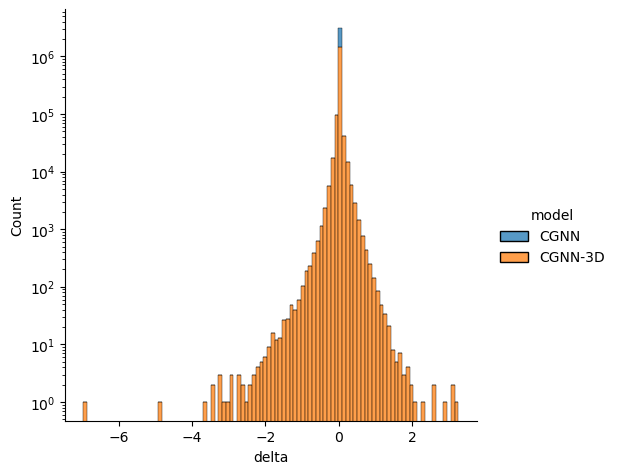

In [15]:
grid = sns.displot(
    attr_df,
    x="delta",
    kind="hist",
    bins=100,
    hue="model",
    multiple="stack",
)
grid.ax.set_yscale("log")

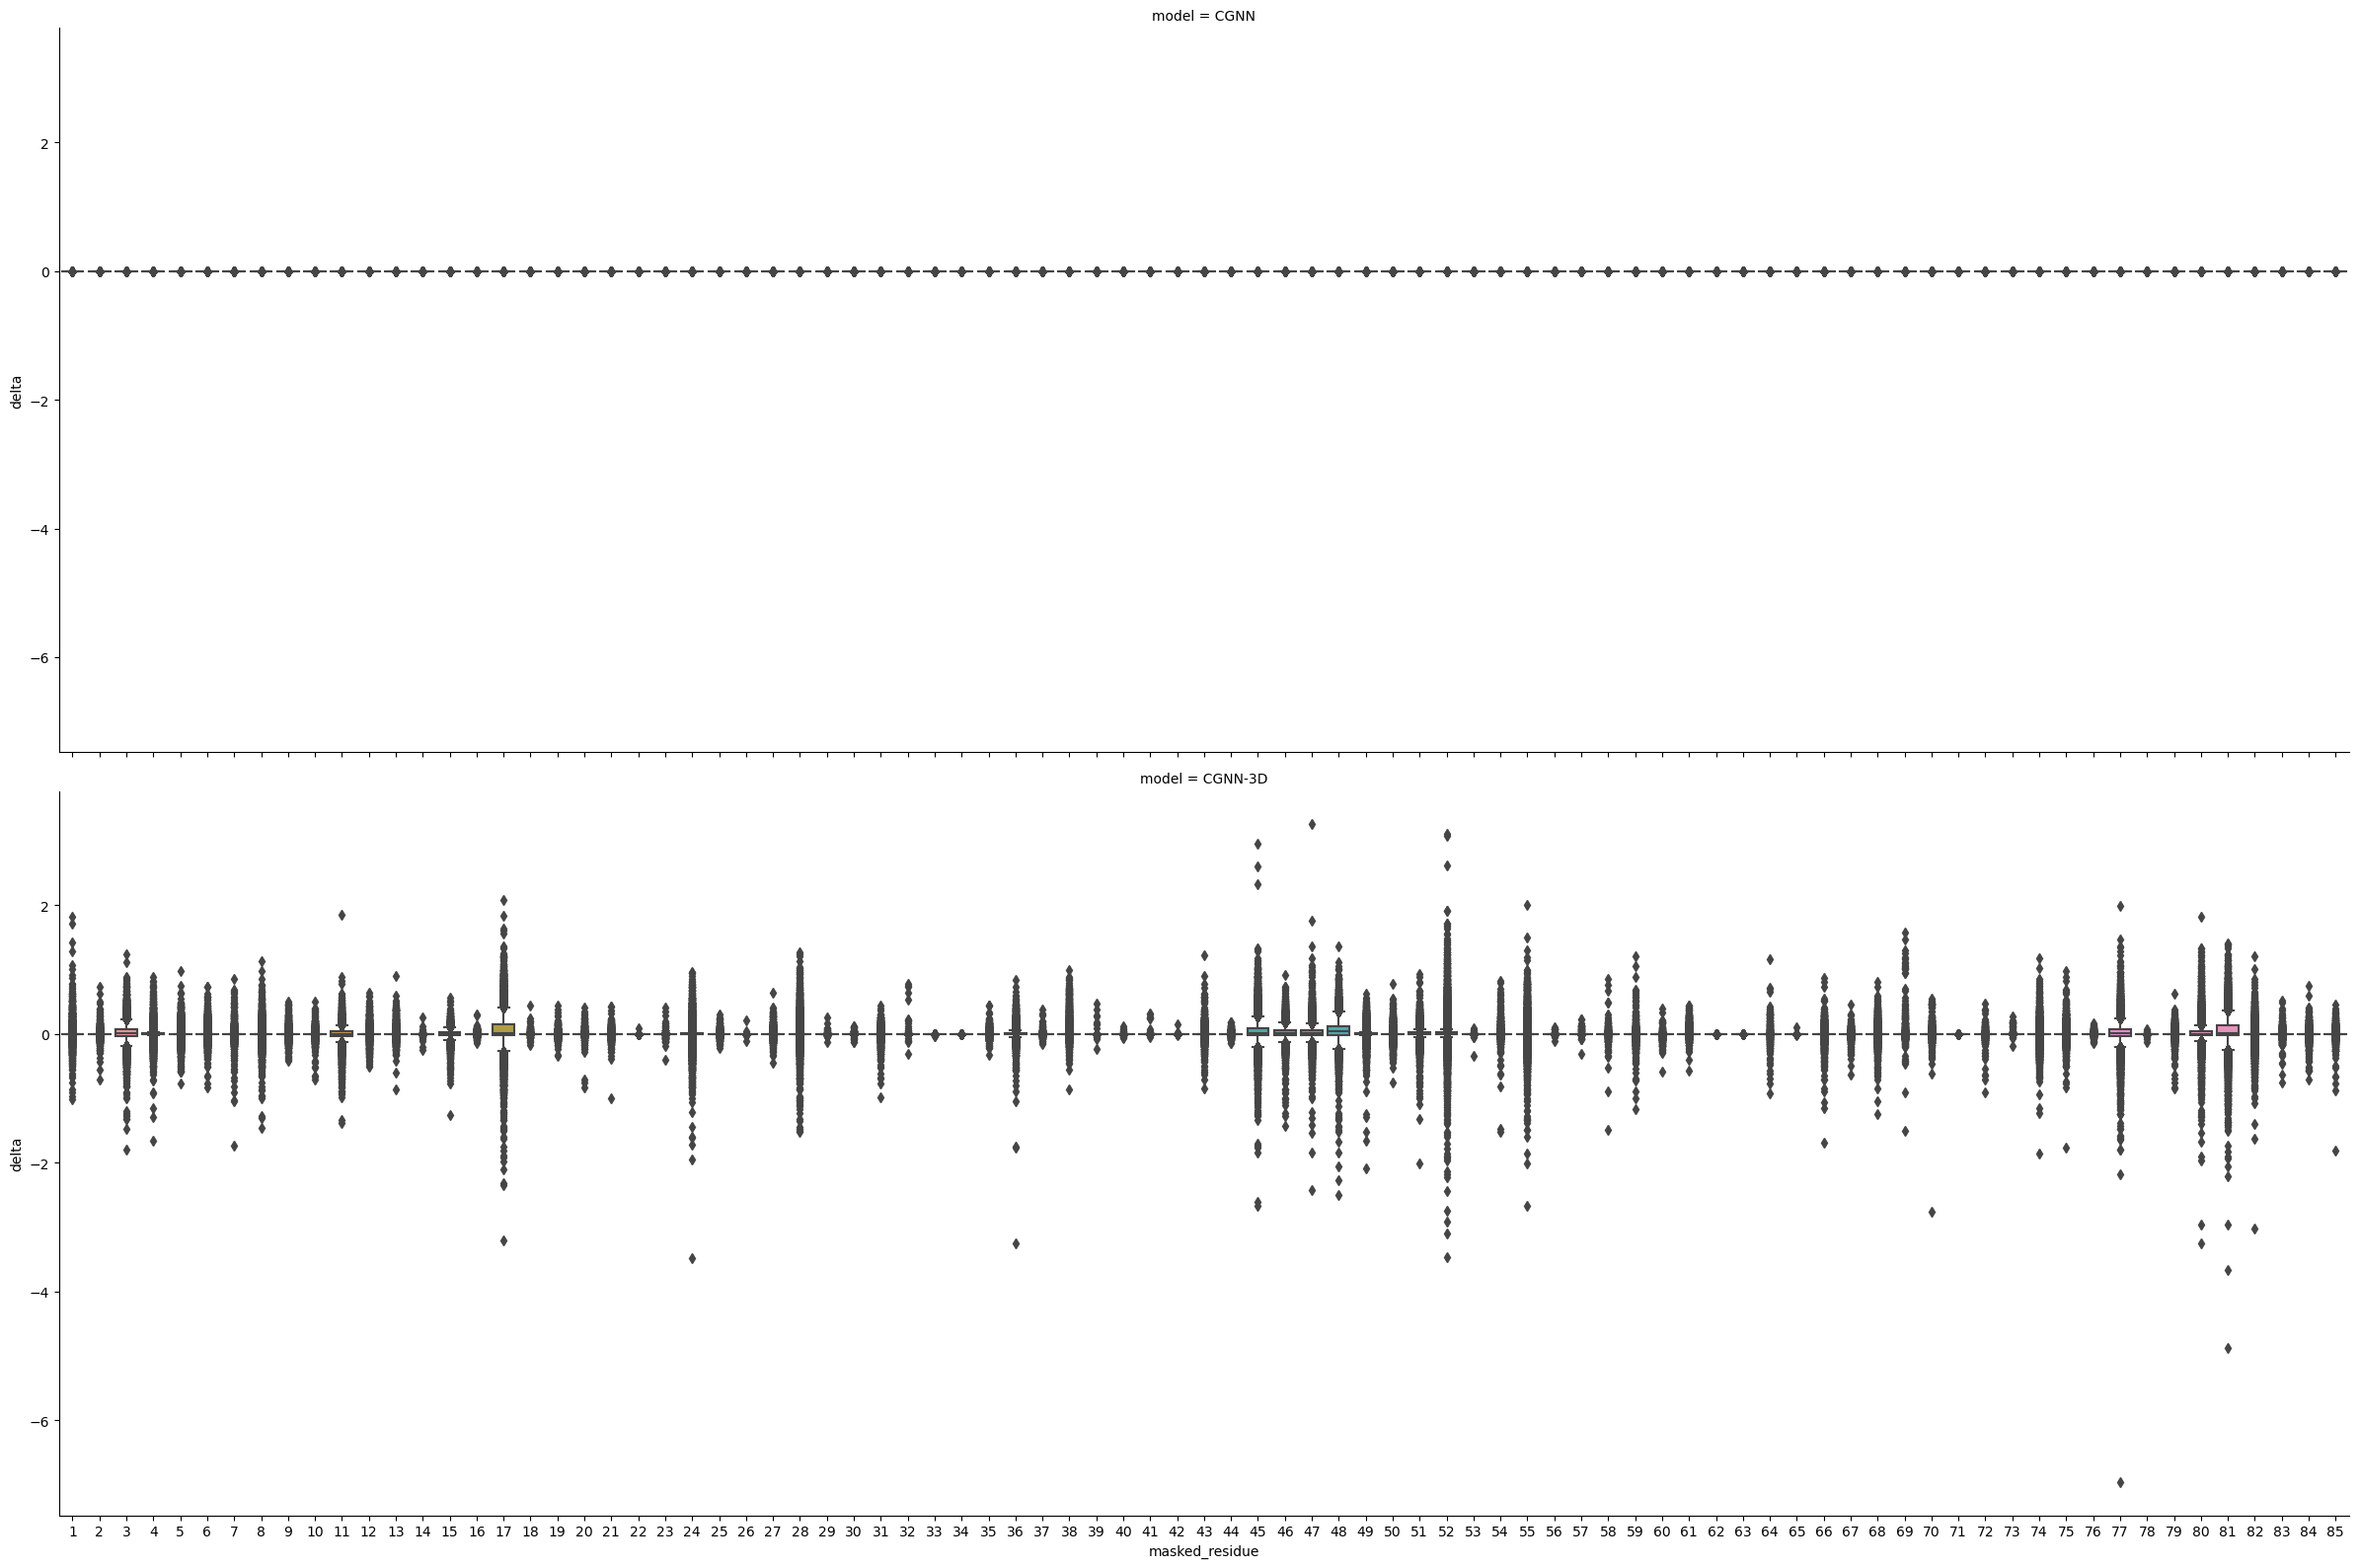

In [16]:
sns.catplot(
    attr_df,
    y="delta",
    x="masked_residue",
    kind="box",
    row="model",
    aspect=3,
    height=8,
    orient="v",
)

In [17]:
def make_var_plot(df):
    delta_var = (
        df.groupby("masked_residue")["delta"].agg("var").to_frame().reset_index()
    )
    fig, ax = plt.subplots(figsize=(18, 6))
    sns.barplot(delta_var, x="masked_residue", y="delta", ax=ax)
    # rotate x labels
    plt.xticks(rotation=90)

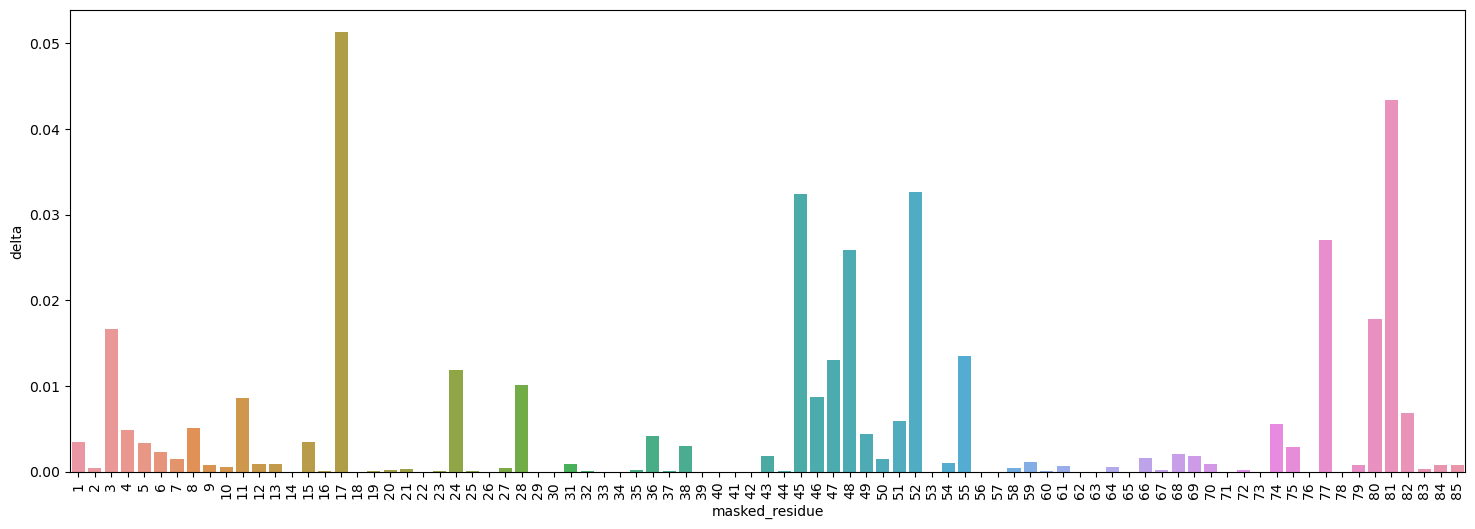

In [18]:
cgnn3d_only = attr_df[attr_df["model"] == "CGNN-3D"]
cgnn_only = attr_df[attr_df["model"] == "CGNN"]
make_var_plot(cgnn3d_only)

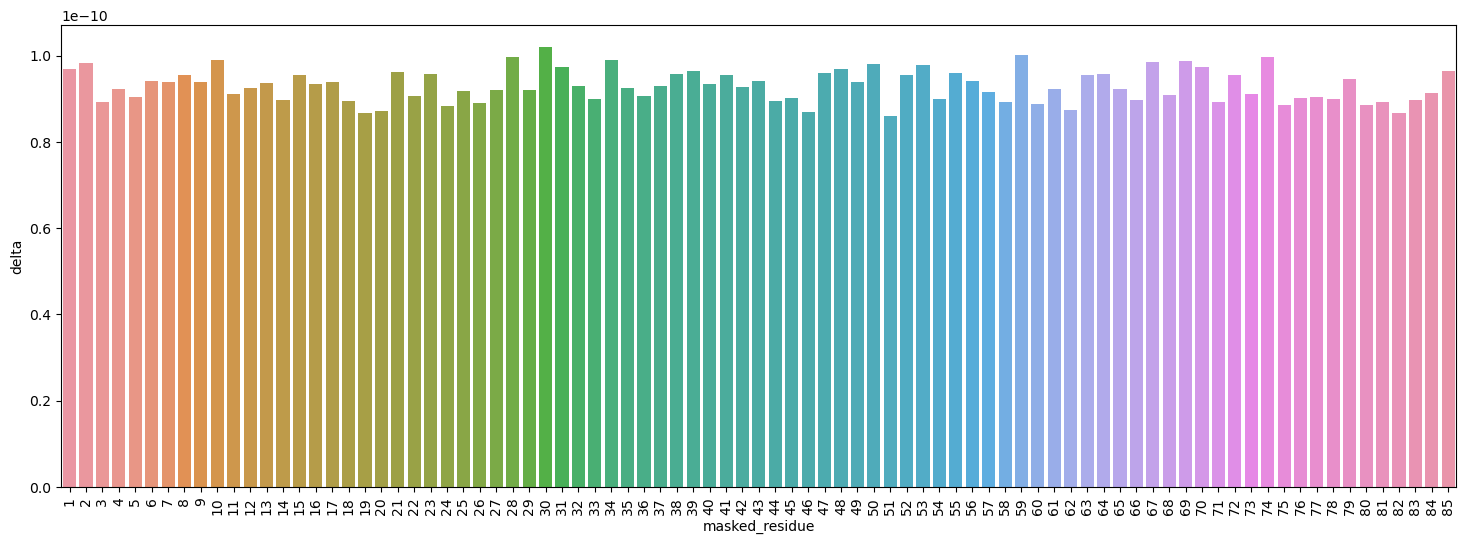

In [19]:
make_var_plot(cgnn_only)

In [20]:
meta_data = pd.read_csv("../data/processed/kinodata_docked.csv")
meta_data.set_index("activities.activity_id", inplace=True)
meta_data.head()

,docking.posit_probability,docking.chemgauss_score,assays.chembl_id,target_dictionary.chembl_id,molecule_dictionary.chembl_id,molecule_dictionary.max_phase,activities.standard_type,activities.standard_units,compound_structures.canonical_smiles,compound_structures.standard_inchi,...,similar.klifs_structure_id,similar.fp_similarity,ID,activities.standard_value,docking.predicted_rmsd,molecule,pocket_mol2_file,ident,structure.pocket_sequence,ligand_size
activities.activity_id,,,,,,,,,,,,,,,,,,,,,
32335,0.18,-13.526784,CHEMBL817617,CHEMBL279,CHEMBL69638,NaN,pIC50,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,InChI=1S/C23H22N4O/c24-22-21-20(14-27(17-8-4-5...,...,5326,0.159664,LIG,5.148742,4.720892,<rdkit.Chem.rdchem.Mol object at 0x30117e420>,/Users/joschkagross/projects/kinodata-3D-affin...,0,KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVE...,28
40693,0.23,-12.693960,CHEMBL817617,CHEMBL279,CHEMBL419082,NaN,pIC50,nM,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2[C@@H]1CCC...,InChI=1S/C23H22N4O2/c24-22-21-18(13-27(23(21)2...,...,5326,0.210526,40693,6.000000,5.268938,<rdkit.Chem.rdchem.Mol object at 0x30117f300>,/Users/joschkagross/projects/kinodata-3D-affin...,17,KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVE...,29
41979,0.50,-16.548706,CHEMBL817617,CHEMBL279,CHEMBL304760,NaN,pIC50,nM,c1ccc(Oc2ccc(Nc3ncnc4ccccc34)cc2)cc1,InChI=1S/C20H15N3O/c1-2-6-16(7-3-1)24-17-12-10...,...,5326,0.273684,LIG,5.565431,1.569232,<rdkit.Chem.rdchem.Mol object at 0x30117f610>,/Users/joschkagross/projects/kinodata-3D-affin...,20,KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVE...,24
51886,0.23,-13.747217,CHEMBL817617,CHEMBL279,CHEMBL69827,NaN,pIC50,nM,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2[C@@H]1C[C...,InChI=1S/C23H22N4O3/c24-22-21-18(14-6-8-17(9-7...,...,5326,0.214286,51886,6.568636,4.824963,<rdkit.Chem.rdchem.Mol object at 0x3011b06d0>,/Users/joschkagross/projects/kinodata-3D-affin...,44,KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVE...,30
443639,0.18,-12.321736,CHEMBL817790,CHEMBL279,CHEMBL302281,NaN,pIC50,nM,CC(C)(C)n1cc(-c2ccc(Oc3ccccc3)cc2)c2c(N)ncnc21,"InChI=1S/C22H22N4O/c1-22(2,3)26-13-18(19-20(23...",...,5326,0.196262,LIG,5.640165,4.742436,<rdkit.Chem.rdchem.Mol object at 0x671c38c10>,/Users/joschkagross/projects/kinodata-3D-affin...,1221,KPLGRGAFGQVIEVAVKMLALMSELKILIHIGLNVVNLLGAMVIVE...,27


## Data loading 2
- residue atom index (ie Map[ident, Map[residue id, pocket atom index of atoms in that residue]])
- Kinodata3D pytorch geometric data objects
- Kinodata3D underlying rdkit mols

In [21]:
from kinodata.data import KinodataDocked
from kinodata.data.dataset import _DATA
from pathlib import Path
from kinodata.transform import TransformToComplexGraph
from tqdm import tqdm
import multiprocessing as mp
import json
from rdkit import Chem
from rdkit.Chem import Draw
import random


RESIDUE_ATOM_INDEX = residue_atom_index_artifact.contents[0]

to_cplx = TransformToComplexGraph()


def get_ident(file: Path):
    ident = int(file.stem.split("_")[-1])
    return ident


def load_single_index(file: Path):
    with open(file, "r") as f:
        try:
            dictionary = json.load(f)
        except json.decoder.JSONDecodeError:
            dictionary = None
    ident = int(file.stem.split("_")[-1])
    return (ident, dictionary)


def load_residue_atom_index(idents, parallelize=False):
    files = list(RESIDUE_ATOM_INDEX.iterdir())
    files = [file for file in files if get_ident(file) in idents]
    assert len(files) == len(idents)
    progressing_iterable = tqdm(files, desc="Loading residue atom index...")
    if parallelize:
        with mp.Pool() as pool:
            tuples = pool.map(load_single_index, progressing_iterable)
    else:
        tuples = [load_single_index(f) for f in progressing_iterable]
    return dict(tuples)

In [22]:
dataset = KinodataDocked()

In [23]:
data_by_ident = {data.ident.item(): data for data in dataset}

In [24]:
mol_source_df = dataset.df

Reading data frame from /Users/joschkagross/projects/kinodata-3D-affinity-prediction/data/raw/kinodata_docked_v2.sdf.gz...
Deduping data frame (current size: 121913)...
119713 complexes remain after deduplication.
Checking for missing pocket mol2 files...


100%|██████████| 3244/3244 [00:00<00:00, 38408.71it/s]


Adding pocket sequences...
(119713, 25)


100%|██████████| 119713/119713 [00:00<00:00, 5460061.49it/s]

Exiting with 3552 cached sequences.
(119713, 26)


In [25]:
mol_source_df.columns

Index(['docking.posit_probability', 'docking.chemgauss_score',
       'activities.activity_id', 'assays.chembl_id',
       'target_dictionary.chembl_id', 'molecule_dictionary.chembl_id',
       'molecule_dictionary.max_phase', 'activities.standard_type',
       'activities.standard_units', 'compound_structures.canonical_smiles',
       'compound_structures.standard_inchi', 'component_sequences.sequence',
       'assays.confidence_score', 'docs.chembl_id', 'docs.year',
       'docs.authors', 'UniprotID', 'similar.klifs_structure_id',
       'similar.fp_similarity', 'ID', 'activities.standard_value',
       'docking.predicted_rmsd', 'molecule', 'pocket_mol2_file', 'ident',
       'structure.pocket_sequence'],
      dtype='object')

In [26]:
mols_by_ident = mol_source_df.set_index("ident")

In [27]:
mol_source_df["activities.activity_id"] = mol_source_df[
    "activities.activity_id"
].astype(int)

In [28]:
mols_by_chembl_id = mol_source_df.set_index("activities.activity_id")

### Add min distance ligand to residue

# TODO

In [29]:
# TODO

## Data loading 3: PLIP interaction data

# TODO

In [30]:
# TODO
# add plip and #plip columns to attr_df

## Data analysis 1: single complex delta analysis

Select a single complex and make select the data that corresponds to that complex.

In [165]:
import random

# set chembl activity id here, ...
# choice = 2390222
choice = 3559317

if choice:
    subs = cgnn3d_only[cgnn3d_only["chembl_activity_id"] == choice]
    ident = subs["ident"].iloc[0]
    chembl_activity_id = choice
# or pick a random one
else:
    ident, index = random.choice(list(cgnn3d_only.groupby("ident").groups.items()))
    ra = load_residue_atom_index([ident])[ident]
    ra = {int(k): v for k, v in ra.items()}
    subs = cgnn3d_only.loc[index]
    chembl_activity_id = subs["chembl_activity_id"].iloc[0]

assert subs["chembl_activity_id"].nunique() == 1
assert subs["ident"].nunique() == 1

print(f"Selected activity {chembl_activity_id} with ident {ident}")
subs["abs_delta"] = np.abs(subs["delta"])
# subs = subs.nlargest(10, "abs_delta")
subs

Selected activity 3559317 with ident 20326


/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_62904/1505282756.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs["abs_delta"] = np.abs(subs["delta"])


,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,abs_delta
25517,20326,3559317,311,48,6.257232,CYS,C,CGNN-3D,6.169103,5.142668,-8.812930e-02,8.812930e-02
53274,20326,3559317,311,26,6.169100,ASN,N,CGNN-3D,6.169103,5.142668,2.400000e-06,2.400000e-06
189801,20326,3559317,311,36,6.158049,VAL,V,CGNN-3D,6.169103,5.142668,1.105410e-02,1.105410e-02
217535,20326,3559317,311,23,6.169103,SER,S,CGNN-3D,6.169103,5.142668,0.000000e+00,0.000000e+00
264562,20326,3559317,311,24,6.169108,GLU,E,CGNN-3D,6.169103,5.142668,-5.700000e-06,5.700000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
3082473,20326,3559317,311,49,6.180510,GLU,E,CGNN-3D,6.169103,5.142668,-1.140730e-02,1.140730e-02
3149315,20326,3559317,311,35,6.169104,ILE,I,CGNN-3D,6.169103,5.142668,-9.000000e-07,9.000000e-07
3157405,20326,3559317,311,81,6.099375,ASP,D,CGNN-3D,6.169103,5.142668,6.972770e-02,6.972770e-02
3280471,20326,3559317,311,18,6.169107,GLU,E,CGNN-3D,6.169103,5.142668,-4.700000e-06,4.700000e-06


In [167]:
subs["masked_residue"]

25517      48
53274      26
189801     36
217535     23
264562     24
           ..
3082473    49
3149315    35
3157405    81
3280471    18
3292469    55
Name: masked_residue, Length: 71, dtype: int64

#### Plot 

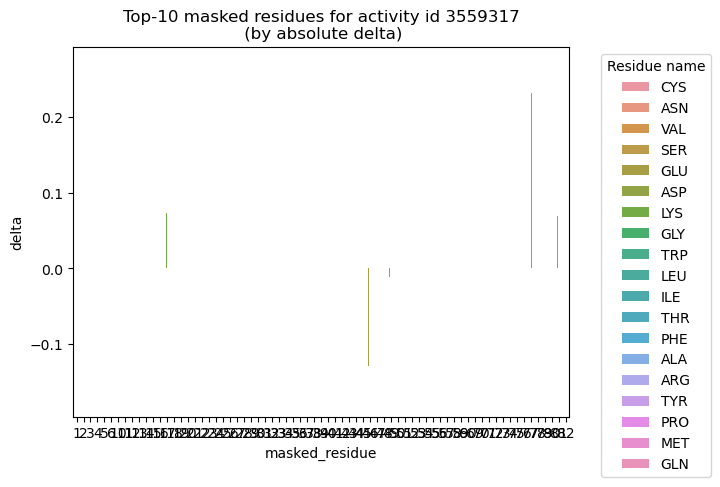

In [168]:
chembl_id = subs["chembl_activity_id"].iloc[0]
ax = sns.barplot(
    subs,
    x="masked_residue",
    y="delta",
    hue="masked_resname",
)
_ = ax.set_title(
    f"Top-10 masked residues for activity id {chembl_id}\n (by absolute delta)"
)
# move legend outside of plot
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1), title="Residue name")

In [170]:
chembl_id = subs["chembl_activity_id"].iloc[0]
meta1 = meta_data.loc[chembl_id]
meta2 = mols_by_chembl_id.loc[chembl_id]
assert meta1.ident == meta2.ident
assert meta1.ident == ident
assert (
    meta1["compound_structures.canonical_smiles"]
    == meta2["compound_structures.canonical_smiles"]
)

In [171]:
mol = meta2.molecule

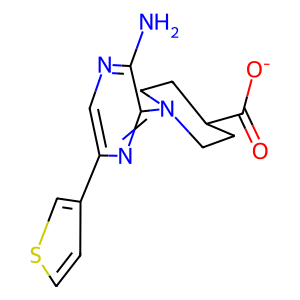

In [172]:
Draw.MolToImage(mol)

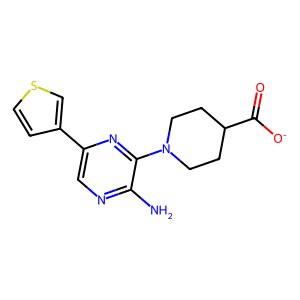

In [173]:
smiles = meta1["compound_structures.canonical_smiles"]
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [174]:
mol.GetNumAtoms(), mol.GetNumBonds()

(21, 23)

In [175]:
data = data_by_ident[ident]
data = to_cplx(data)

In [176]:
data["ligand"].z.shape, data["ligand", "bond", "ligand"].edge_index.shape

(torch.Size([21]), torch.Size([2, 46]))

In [177]:
n_ligand_atoms = data["ligand"].z.shape[0]

In [178]:
from collections import defaultdict

count_rd = defaultdict(int)
count_pt = defaultdict(int)

for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    num_rd = atom.GetAtomicNum()
    num_pt = data["complex"].z[-n_ligand_atoms:][idx].item()

    count_rd[num_rd] += 1
    count_pt[num_pt] += 1
    assert num_rd - num_pt == 0

In [179]:
count_rd

defaultdict(int, {6: 14, 7: 4, 8: 2, 16: 1})

In [180]:
count_pt

defaultdict(int, {6: 14, 7: 4, 8: 2, 16: 1})

In [181]:
from kinodata.model.complex_transformer import StructuralInteractions
import torch

intr = StructuralInteractions(4, interaction_radius=5, rbf_size=4)


@torch.inference_mode()
def get_edge_index_and_distances(data):
    edge_index, _, distances = intr.interactions(data)
    return edge_index, distances

In [182]:
data["complex"].batch = torch.zeros(data["complex"].z.shape[0], dtype=torch.long)
edge_index, distances = get_edge_index_and_distances(data)

In [183]:
atom_index_to_residue = defaultdict(list)
for residue_index, atom_indices in ra.items():
    for atom_index in atom_indices:
        atom_index_to_residue[atom_index].append(residue_index)
for lst in atom_index_to_residue.values():
    assert len(lst) == 1
atom_index_to_residue = {k: v[0] for k, v in atom_index_to_residue.items()}

In [184]:
n_pocket_atoms = data["complex"].z.shape[0] - n_ligand_atoms

edge_set = set([tuple(edge) for edge in edge_index.T.numpy()])

ligand_atom_attr = torch.zeros((n_ligand_atoms, 85), dtype=torch.long)

residue_index_to_connected_ligand_atoms = defaultdict(list)

for i, j in edge_set:
    if i > j:
        i, j = j, i
    is_i_pocket_atom = i < n_pocket_atoms
    if not is_i_pocket_atom:
        continue
    is_j_ligand_atom = j >= n_pocket_atoms
    if not is_j_ligand_atom:
        continue

    residue_index = atom_index_to_residue[i]
    residue_index_to_connected_ligand_atoms[residue_index].append(
        int(j - n_pocket_atoms)
    )
    ligand_atom_attr[j - n_pocket_atoms, residue_index] = 1

In [185]:
ligand_atom_attr.sum(dim=0)

tensor([ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  3,  0,  5,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         3,  0,  3,  0,  0,  0,  0,  0,  0,  7,  3,  3,  8,  1,  0,  5,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 11,  0,  0,  0,  5,  0,  0,  0])

In [186]:
residue_index_to_resname = subs.set_index("masked_residue")[["masked_resname", "delta"]]
residue_index_to_resname.shape

(71, 2)

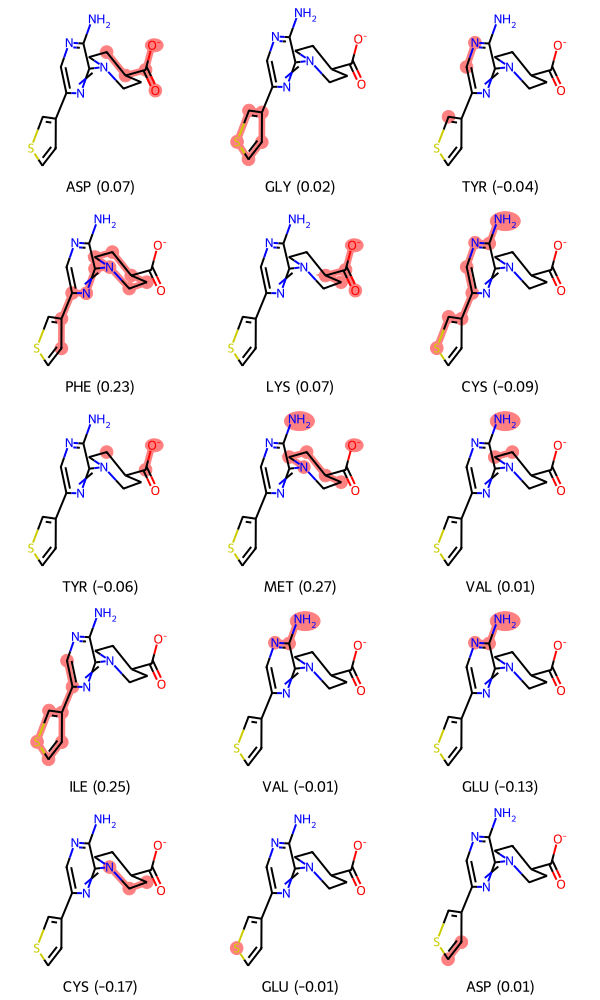

In [187]:
highlights = [
    v
    for k, v in residue_index_to_connected_ligand_atoms.items()
    if k in residue_index_to_resname.index
]
resnames = [
    residue_index_to_resname.loc[k]["masked_resname"]
    for k in residue_index_to_connected_ligand_atoms.keys()
    if k in residue_index_to_resname.index
]
delta = [
    residue_index_to_resname.loc[k]["delta"]
    for k in residue_index_to_connected_ligand_atoms.keys()
    if k in residue_index_to_resname.index
]
legend = [f"{name} ({delta:.2f})" for name, delta in zip(resnames, delta)]
Draw.MolsToGridImage(
    [mol] * len(highlights),
    highlightAtomLists=highlights,
    legends=legend,
)

In [188]:
subs

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,abs_delta
25517,20326,3559317,311,48,6.257232,CYS,C,CGNN-3D,6.169103,5.142668,-8.812930e-02,8.812930e-02
53274,20326,3559317,311,26,6.169100,ASN,N,CGNN-3D,6.169103,5.142668,2.400000e-06,2.400000e-06
189801,20326,3559317,311,36,6.158049,VAL,V,CGNN-3D,6.169103,5.142668,1.105410e-02,1.105410e-02
217535,20326,3559317,311,23,6.169103,SER,S,CGNN-3D,6.169103,5.142668,0.000000e+00,0.000000e+00
264562,20326,3559317,311,24,6.169108,GLU,E,CGNN-3D,6.169103,5.142668,-5.700000e-06,5.700000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
3082473,20326,3559317,311,49,6.180510,GLU,E,CGNN-3D,6.169103,5.142668,-1.140730e-02,1.140730e-02
3149315,20326,3559317,311,35,6.169104,ILE,I,CGNN-3D,6.169103,5.142668,-9.000000e-07,9.000000e-07
3157405,20326,3559317,311,81,6.099375,ASP,D,CGNN-3D,6.169103,5.142668,6.972770e-02,6.972770e-02
3280471,20326,3559317,311,18,6.169107,GLU,E,CGNN-3D,6.169103,5.142668,-4.700000e-06,4.700000e-06


In [190]:
# get diverging color map
from matplotlib import cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=min(subs["delta"]), vmax=max(subs["delta"]))
cmap = cm.get_cmap("coolwarm")
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)


def map_to_hex(val):
    rgba = cmapper.to_rgba(val)
    hex_color = f"#{''.join(f'{int(255 * x):02x}' for x in rgba[:3])}"
    return hex_color

In [191]:
# display hex colors for testing
hex_colors = [
    map_to_hex(val / 10)
    for val in range(
        -10,
        10,
    )
]
hex_colors

['#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#3a4cc0',
 '#6f91f2',
 '#bdd2f6',
 '#f3c6b0',
 '#e57057',
 '#b30326',
 '#b30326',
 '#b30326',
 '#b30326',
 '#b30326',
 '#b30326',
 '#b30326']

In [192]:
subs["colorcode"] = subs["delta"].apply(map_to_hex)
subs

/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_62904/149111484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs["colorcode"] = subs["delta"].apply(map_to_hex)


,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,abs_delta,colorcode
25517,20326,3559317,311,48,6.257232,CYS,C,CGNN-3D,6.169103,5.142668,-8.812930e-02,8.812930e-02,#789bf7
53274,20326,3559317,311,26,6.169100,ASN,N,CGNN-3D,6.169103,5.142668,2.400000e-06,2.400000e-06,#bdd2f6
189801,20326,3559317,311,36,6.158049,VAL,V,CGNN-3D,6.169103,5.142668,1.105410e-02,1.105410e-02,#c5d5f2
217535,20326,3559317,311,23,6.169103,SER,S,CGNN-3D,6.169103,5.142668,0.000000e+00,0.000000e+00,#bdd2f6
264562,20326,3559317,311,24,6.169108,GLU,E,CGNN-3D,6.169103,5.142668,-5.700000e-06,5.700000e-06,#bdd2f6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082473,20326,3559317,311,49,6.180510,GLU,E,CGNN-3D,6.169103,5.142668,-1.140730e-02,1.140730e-02,#b4cdfa
3149315,20326,3559317,311,35,6.169104,ILE,I,CGNN-3D,6.169103,5.142668,-9.000000e-07,9.000000e-07,#bdd2f6
3157405,20326,3559317,311,81,6.099375,ASP,D,CGNN-3D,6.169103,5.142668,6.972770e-02,6.972770e-02,#e8d5ca
3280471,20326,3559317,311,18,6.169107,GLU,E,CGNN-3D,6.169103,5.142668,-4.700000e-06,4.700000e-06,#bdd2f6


In [193]:
@dataclass
class ColorCommand:
    colorcode: str
    residue_index: int

    def __str__(self):
        return f"color :{self.residue_index} {self.colorcode}"

In [194]:
def write(
    commands: list[ColorCommand],
    file: Path,
):
    content = "\n".join(str(command) for command in commands)
    file.write_text(content)
    return content

In [195]:
from kinodata.data.io.read_klifs_mol2 import read_klifs_mol2

In [196]:
klifs_id = subs["klifs_structure_id"].unique()[0]
klifs_id

311

In [197]:
pocket_file = Path(f"../data/raw/mol2/pocket/{klifs_id}_pocket.mol2")
pocket_file.exists()

True

In [201]:
mol2_meta = read_klifs_mol2(pocket_file, with_bonds=False)
subs["residue.subst_id"] = subs["masked_residue"]
mol2_meta

/var/folders/gp/_kdyh3hn1yv47p6w56krv9000000gn/T/ipykernel_62904/3272638441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs["residue.subst_id"] = subs["masked_residue"]


,atom.id,atom.name,atom.x,atom.y,atom.z,atom.type,residue.subst_id,residue.subst_name,atom.charge,atom.status_bit
0,1,N,6.5345,17.508301,53.369499,N.3,1,TYR12,-0.6701,BACKBONE
1,2,H,6.2365,18.157000,52.654999,H,1,TYR12,0.3700,BACKBONE
2,3,CA,6.5656,16.083401,53.066200,C.3,1,TYR12,0.2811,BACKBONE
3,4,HA,7.5561,15.718200,53.337601,H,1,TYR12,0.0800,BACKBONE
4,5,C,6.3512,15.821300,51.581299,C.2,1,TYR12,0.5090,BACKBONE
...,...,...,...,...,...,...,...,...,...,...
1147,1148,HE1,-1.9117,22.513599,29.347000,H,71,PHE160,0.1500,<NA>
1148,1149,CE2,-0.4286,23.096100,32.313599,C.ar,71,PHE160,-0.1500,<NA>
1149,1150,HE2,-0.6516,23.463900,33.304298,H,71,PHE160,0.1500,<NA>
1150,1151,CZ,-1.4233,23.031000,31.360300,C.ar,71,PHE160,-0.1500,<NA>


In [199]:
mol2_meta = mol2_meta[["residue.subst_id", "residue.subst_name"]].drop_duplicates()
mol2_meta.head()

,residue.subst_id,residue.subst_name
0,1,TYR12
21,2,THR13
35,3,ILE14
54,4,GLY15
61,5,THR16


In [200]:
subs_with_mol2 = pd.merge(subs, mol2_meta, on="residue.subst_id", how="left")
subs_with_mol2

,ident,chembl_activity_id,klifs_structure_id,masked_residue,masked_pred,masked_resname,masked_res_letter,model,reference_pred,target,delta,abs_delta,colorcode,residue.subst_id,residue.subst_name
0,20326,3559317,311,48,6.257232,CYS,C,CGNN-3D,6.169103,5.142668,-8.812930e-02,8.812930e-02,#789bf7,48,GLY92
1,20326,3559317,311,26,6.169100,ASN,N,CGNN-3D,6.169103,5.142668,2.400000e-06,2.400000e-06,#bdd2f6,26,ARG60
2,20326,3559317,311,36,6.158049,VAL,V,CGNN-3D,6.169103,5.142668,1.105410e-02,1.105410e-02,#c5d5f2,36,TYR71
3,20326,3559317,311,23,6.169103,SER,S,CGNN-3D,6.169103,5.142668,0.000000e+00,0.000000e+00,#bdd2f6,23,ASN57
4,20326,3559317,311,24,6.169108,GLU,E,CGNN-3D,6.169103,5.142668,-5.700000e-06,5.700000e-06,#bdd2f6,24,LEU58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,20326,3559317,311,49,6.180510,GLU,E,CGNN-3D,6.169103,5.142668,-1.140730e-02,1.140730e-02,#b4cdfa,49,ASP93
67,20326,3559317,311,35,6.169104,ILE,I,CGNN-3D,6.169103,5.142668,-9.000000e-07,9.000000e-07,#bdd2f6,35,TYR70
68,20326,3559317,311,81,6.099375,ASP,D,CGNN-3D,6.169103,5.142668,6.972770e-02,6.972770e-02,#e8d5ca,81,<NA>
69,20326,3559317,311,18,6.169107,GLU,E,CGNN-3D,6.169103,5.142668,-4.700000e-06,4.700000e-06,#bdd2f6,18,LEU52


In [95]:
commands = []
for index, row in subs_with_mol2.iterrows():
    resid_index = int(row["residue.subst_name"][-3:])
    commands.append(
        ColorCommand(
            colorcode=row["colorcode"],
            residue_index=resid_index,
        )
    )
commands

[ColorCommand(colorcode='#8eb1fd', residue_index=814),
 ColorCommand(colorcode='#f3c5af', residue_index=836),
 ColorCommand(colorcode='#bed3f5', residue_index=677),
 ColorCommand(colorcode='#f1cab6', residue_index=627),
 ColorCommand(colorcode='#f1cab6', residue_index=816),
 ColorCommand(colorcode='#eecfbe', residue_index=676),
 ColorCommand(colorcode='#ecd2c4', residue_index=837),
 ColorCommand(colorcode='#e9d4c9', residue_index=674),
 ColorCommand(colorcode='#e7d6cd', residue_index=644),
 ColorCommand(colorcode='#d6dbe4', residue_index=672)]

In [93]:
print(write(commands, Path("test.cxc")))

color :814 #8eb1fd
color :836 #f3c5af
color :677 #bed3f5
color :627 #f1cab6
color :816 #f1cab6
color :676 #eecfbe
color :837 #ecd2c4
color :674 #e9d4c9
color :644 #e7d6cd
color :672 #d6dbe4
